# Small Signal Model of BJT with Noise

In this example, a small signal model with noise is constructed for an NPN transistor. For the purpose of understanding how to construct circuits from two-port networks, we do this three different ways:



1. The long way, where individual network matricies are built and use two-port combinations to make the final circuit
2. The shorter way, where the individual network matricies are mostly constructed from circuit components found in the components library
3. The short way, where a BJT model from the components library is used directly

All methods produce the same results.

![Small Signal NPN](images/SVG/SmallSigBJT1.svg)



The small signal model implemented here is the Gummel-Poon model implemented in SPICE. You can learn more about the model in "Semiconductor Device Modeling with SPICE" [1]. There are a couple discrepances between the model here and the SPICE model: first, the examples here assume Cjx and Cjs are zero (see the last example for a picture of where those capacitors reside); second, the reverse transconductance is assumed to be zero (which will be true in the majority of cases).


## The Long Way
Individual network matrices are constucted and set to be passive for thermal noise. For shot noise, the covariance matrix is constructed.

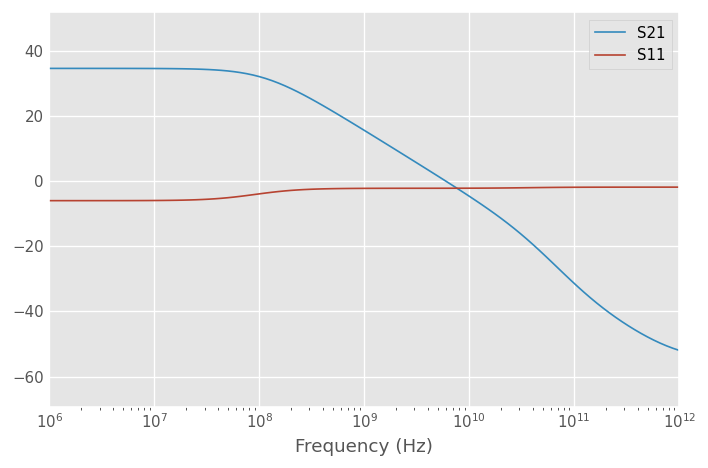

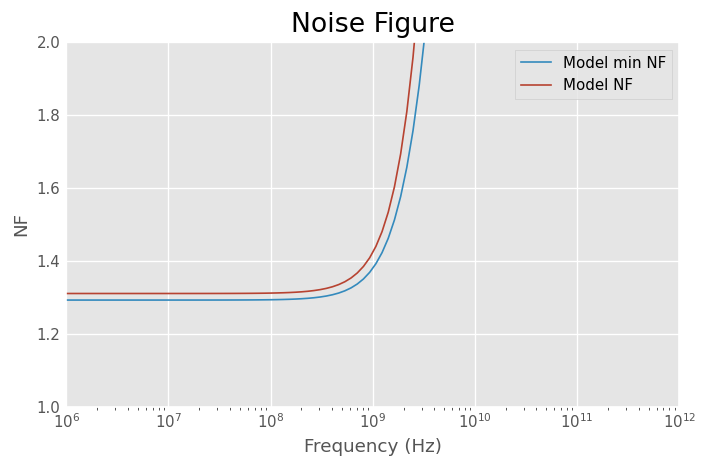

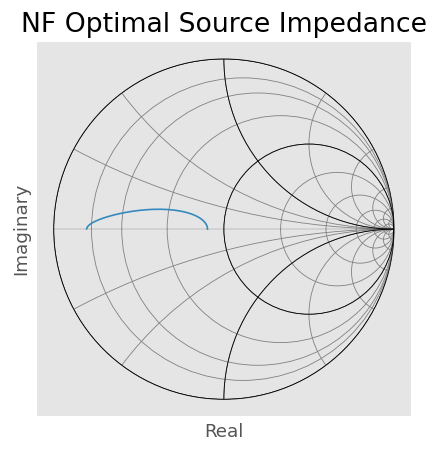

In [1]:
import skrf as rf
import numpy as npy
from skrf.constants import *
from skrf import mathFunctions as mf
%matplotlib inline
from pylab import * 
rf.stylely()

z0 = 50
T0 = 290. 
kB = K_BOLTZMANN
frequency = rf.Frequency(start=1000000, stop=1000000000000, npoints=100, unit='Hz', sweep_type='log')

# These parameters are required by the model
Ic_ma = 20.1 # bias current in milliamps
beta0 = 107.7 # current gain
cpi = 3.9e-12
cu = 0.8e-12
rbb = 5.303 # base spreading resistance
ru = 100e9
rc = 0.5
re = 0.05
r0 = 1e4

# These are derived parameters
gm = Ic_ma/26 # transconductance
rpi = beta0/gm # input resistance
gpi = 1/rpi
scpi = 1j*frequency.w*cpi
scu = 1j*frequency.w*cu
sug_d = scu - gm

ovec = npy.ones(len(frequency))
zvec = npy.zeros(len(frequency))

# Series base spreading resistance connected to base
rbb_series_y = rf.network_array([[1/rbb*ovec,  -1/rbb*ovec],
                                 [-1/rbb*ovec,  1/rbb*ovec]])
nwrk_rbb = rf.NoisyNetwork.from_y(rbb_series_y, frequency=frequency)
# See simple_noise_cascade.ipynb if you want to add the covariance matrix yourself. Here we use the 'passive' parameter, which calculates the covariance matrix for you.
nwrk_rbb.noise_source('passive')

# Series resistance connected to collector 
rc_series_y = rf.network_array([[1/rc*ovec,  -1/rc*ovec],
                                [-1/rc*ovec,  1/rc*ovec]])
nwrk_rc = rf.NoisyNetwork.from_y(rc_series_y, frequency=frequency)
nwrk_rc.noise_source('passive')

# Shunt resistor connected to emitter of transistor
re_shunt_z = rf.network_array([[re*ovec,  re*ovec],
                                [re*ovec,  re*ovec]])
nwrk_re = rf.NoisyNetwork.from_z(re_shunt_z, frequency=frequency)
nwrk_re.noise_source('passive')

# Series resistor parallel to common emitter 
ru_series_y = rf.network_array([[1/ru*ovec,  -1/ru*ovec],
                                [-1/ru*ovec,  1/ru*ovec]])
nwrk_ru = rf.NoisyNetwork.from_y(ru_series_y, frequency=frequency)
nwrk_ru.noise_source('passive')

# Shunted resistance between collector and emitter
r0_shunt_z = rf.network_array([[r0*ovec,  r0*ovec],
                                [r0*ovec,  r0*ovec]])
nwrk_r0 = rf.NoisyNetwork.from_z(r0_shunt_z, frequency=frequency)
nwrk_r0.noise_source('passive')         

# The next few networks are combined to create the current source with parasitic capacitance. 
gpi_shunt_a = rf.network_array([[ovec,     zvec],
                                [gpi*ovec, ovec]])

cpi_shunt_a = rf.network_array([[ovec,     zvec],
                                [scpi*ovec, ovec]])

cug_shfb_a = rf.network_array([[scu/sug_d,     ovec/sug_d],
                               [scu*gm/sug_d,   scu/sug_d]])

# Multiply each ABCD form above for inner BJT model
a_bjt = npy.matmul(gpi_shunt_a, npy.matmul(cpi_shunt_a, cug_shfb_a))

# This covariance matrix that accounts for the shot noise within the BJT
cov_bjt_y = 2*kB*T0*gm*rf.network_array([[1/beta0*ovec,  zvec],
                                       [zvec,          ovec]])

nwrk_inner_bjt = rf.NoisyNetwork.from_a(a_bjt, frequency=frequency)
shot_noise_cov_y = rf.NetworkNoiseCov(cov_bjt_y, form='y')
nwrk_inner_bjt.noise_source(shot_noise_cov_y)

# Combine the networks together for the full Common Emitter two-port BJT model
ntwkT = rf.parallel_parallel_2port(nwrk_inner_bjt, nwrk_ru)
ntwkT = rf.cascade_2port(nwrk_rbb, ntwkT)
ntwkT = rf.cascade_2port(ntwkT, nwrk_r0)
ntwkT = rf.series_series_2port(ntwkT, nwrk_re)
ntwkT = rf.cascade_2port(ntwkT, nwrk_rc)

model_nfmin_db = ntwkT.nfmin_db
model_nf_db = ntwkT.nf_db(z0)
#sparams = mf.complex_2_db(ntwkT.s)
sparams = ntwkT.s_db

from skrf.plotting import func_on_all_figs as foaf

figure(0)
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
#semilogx(frequency.f_scaled, sparams[:,0,1], label=r'S12')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
#semilogx(frequency.f_scaled, sparams[:,1,1], label=r'S22')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')

ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()

figure(2)
rf.plotting.plot_smith(ntwkT.g_opt, title="NF Optimal Source Impedance")

## The Shorter Way
Thermal components are constructed using scikit-rf RLC components. Shot noise is still modeled using a covariance matrix.

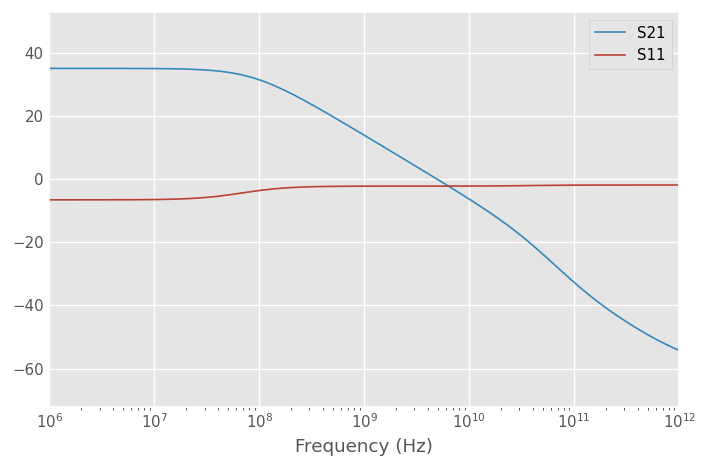

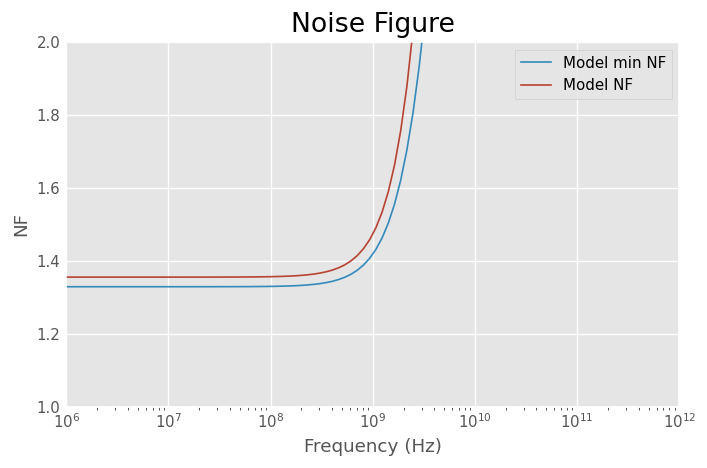

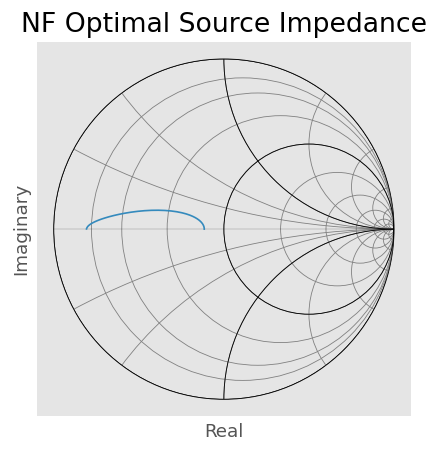

In [2]:
 import skrf as rf
import numpy as npy
from skrf.constants import *
from skrf import mathFunctions as mf
%matplotlib inline
from pylab import * 
rf.stylely()

z0 = 50
T0 = 290. 
kB = K_BOLTZMANN
frequency = rf.Frequency(start=1000000, stop=1000000000000, npoints=100, unit='Hz', sweep_type='log')

Ic_ma = 21.5 
beta0 = 107.7 
cpi = 4e-12
cu = 1e-12
rbb = 5.303
ru = 100e9
rc = 0.3741
re = 0.03041
r0 = 1e4


nwrk_rbb = rf.noisyComponents.RLC_Series_2port(R=rbb, frequency=frequency, T0 = 290)
nwrk_rc = rf.noisyComponents.RLC_Series_2port(R=rc, frequency=frequency, T0 = 290)
nwrk_re = rf.noisyComponents.RLC_Shunt_2port(R=re, frequency=frequency, T0 = 290)
nwrk_ru = rf.noisyComponents.RLC_Series_2port(R=ru, frequency=frequency, T0 = 290)
nwrk_r0 = rf.noisyComponents.RLC_Shunt_2port(R=r0, frequency=frequency, T0 = 290)

gm = Ic_ma/26 # transconductance
rpi = beta0/gm # input resistance

nwrk_rpi_cpi = rf.noisyComponents.RLC_Shunt_2port(R=rpi, C=cpi, frequency=frequency, T0 = 290)
nwrk_rpi_cpi.noise_source('none') # transconductance doesn't generate thermal noise

scu = 1j*frequency.w*cu
sug_d = scu - gm
cug_shfb_a = rf.network_array([[scu/sug_d,     1/sug_d],
                               [scu*gm/sug_d,   scu/sug_d]])
nwrk_inner_bjt = rf.Network.from_a(cug_shfb_a, frequency=frequency)
nwrk_inner_bjt.noise_source('none')

ntwk_bjt_shot_noise = rf.cascade_2port(nwrk_rpi_cpi, nwrk_inner_bjt)

# Model the shot noise using y form of the covariance matrix
ovec = npy.ones(len(frequency))
zvec = npy.zeros(len(frequency))
cov_bjt_y = 2*kB*290*gm*rf.network_array([[1/beta0*ovec,  zvec],
                                         [zvec,          ovec]])

ntwk_bjt_shot_noise.noise_source(rf.NetworkNoiseCov(cov_bjt_y, form='y'))


ntwkT = rf.parallel_parallel_2port(ntwk_bjt_shot_noise, nwrk_ru)
ntwkT = rf.cascade_2port(nwrk_rbb, ntwkT)
ntwkT = rf.cascade_2port(ntwkT, nwrk_r0)
ntwkT = rf.series_series_2port(ntwkT, nwrk_re)
ntwkT = rf.cascade_2port(ntwkT, nwrk_rc)

model_nfmin_db = ntwkT.nfmin_db
model_nf_db = ntwkT.nf_db(z0)
sparams = ntwkT.s_db

from skrf.plotting import func_on_all_figs as foaf

figure(0)
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
#semilogx(frequency.f_scaled, sparams[:,0,1], label=r'S12')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
#semilogx(frequency.f_scaled, sparams[:,1,1], label=r'S22')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')

ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()

figure(2)
rf.plotting.plot_smith(ntwkT.g_opt, title="NF Optimal Source Impedance")

## The Short Way
Using the above code, a new component was made called SmallSig_NPN_BJT_CE_2port. 

![Small Signal NPN Gummel-Poon](images/SVG/SmallSigBJT2.svg)

In [ ]:
import skrf as rf
import numpy as npy
from skrf.constants import *
from skrf import mathFunctions as mf
%matplotlib inline
from pylab import * 
rf.stylely()

Ic_ma = 21.5 # bias current in milliamps
beta0 = 107.7 # current gain,
cpi = 4e-12
cu = 1e-12
rbb = 5.303
ru = 100e9
rc = 0.3741
re = 0.03041
r0 = 1e4
cjx = 1e-18
cjs = 1e-18

frequency = rf.Frequency(start=1000000, stop=1000000000000, npoints=100, unit='Hz', sweep_type='log')

ntwkT = rf.noisyComponents.SmallSig_NPN_BJT_CE_2port(Ic_ma, beta0, cpi, cu, rbb, rc, re, ru, r0, cjx, cjs, 
                                                frequency = frequency, T0 = 300)


model_nfmin_db = ntwkT.nfmin_db
z0 = 50
model_nf_db = ntwkT.nf_db(z0)
sparams = ntwkT.s_db
npy.max(sparams)                                

from skrf.plotting import func_on_all_figs as foaf

figure(0)
semilogx(frequency.f_scaled, sparams[:,1,0], label=r'S21')
#semilogx(frequency.f_scaled, sparams[:,0,1], label=r'S12')
semilogx(frequency.f_scaled, sparams[:,0,0], label=r'S11')
#semilogx(frequency.f_scaled, sparams[:,1,1], label=r'S22')
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)
tight_layout()

figure(1)
ylabel('NF')
title('Noise Figure')
semilogx(frequency.f_scaled, model_nfmin_db, label=r'Model min NF')
semilogx(frequency.f_scaled, model_nf_db, label=r'Model NF')
#print(npy.min(model_nfmin_db))
#print(npy.min(model_nf_db))

ylim(1,2)
foaf(frequency.labelXAxis)
foaf(tight_layout)
foaf(legend)
#foaf(loglog)

tight_layout()

figure(2)
rf.plotting.plot_smith(ntwkT.g_opt, title="NF Optimal Source Impedance")

More Examples:
- More on constructing noisy two-port models: simple_noise_cascade.ipynb
- A comparison between the BJT model here and the BJT model within QucsStudio: bjt_noise_model_compare_w_qucs.ipynb 

## References
- [1] Antognetti, Paolo, Giuseppe Massobrio, and Guiseppe Massobrio. Semiconductor device modeling with SPICE. McGraw-Hill, Inc., 1993.